In [89]:
"""
Customer Clustering using K-means and Hierarchical Clustering.
Author: Rainy
Date: 10/02/2019
"""

'\nCustomer Clustering using K-means and Hierarchical Clustering.\nAuthor: Rainy\nDate: 10/02/2019\n'

In [2]:
# Set up
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
# load data
# data source: https://github.com/mdancho84/orderSimulatoR/tree/master/data
df_bike = pd.read_excel('bikes.xlsx', sheetname='Sheet1')

In [4]:
df_shops = pd.read_excel('bikeshops.xlsx', sheetname='Sheet1')

In [5]:
df_order = pd.read_excel('orders.xlsx', sheetname = 'Sheet1')

In [6]:
# inspection
df_bike.info(), df_bike.isnull().any()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 6 columns):
bike.id      97 non-null int64
model        97 non-null object
category1    97 non-null object
category2    97 non-null object
frame        97 non-null object
price        97 non-null int64
dtypes: int64(2), object(4)
memory usage: 4.6+ KB


(None, bike.id      False
 model        False
 category1    False
 category2    False
 frame        False
 price        False
 dtype: bool)

In [7]:
df_bike.head()

,bike.id,model,category1,category2,frame,price
0,1,Supersix Evo Black Inc.,Road,Elite Road,Carbon,12790
1,2,Supersix Evo Hi-Mod Team,Road,Elite Road,Carbon,10660
2,3,Supersix Evo Hi-Mod Dura Ace 1,Road,Elite Road,Carbon,7990
3,4,Supersix Evo Hi-Mod Dura Ace 2,Road,Elite Road,Carbon,5330
4,5,Supersix Evo Hi-Mod Utegra,Road,Elite Road,Carbon,4260


In [8]:
df_shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 6 columns):
bikeshop.id       30 non-null int64
bikeshop.name     30 non-null object
bikeshop.city     30 non-null object
bikeshop.state    30 non-null object
latitude          30 non-null float64
longitude         30 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 1.5+ KB


In [9]:
df_shops.head()

,bikeshop.id,bikeshop.name,bikeshop.city,bikeshop.state,latitude,longitude
0,1,Pittsburgh Mountain Machines,Pittsburgh,PA,40.440625,-79.995886
1,2,Ithaca Mountain Climbers,Ithaca,NY,42.443961,-76.501881
2,3,Columbus Race Equipment,Columbus,OH,39.961176,-82.998794
3,4,Detroit Cycles,Detroit,MI,42.331427,-83.045754
4,5,Cincinnati Speed,Cincinnati,OH,39.103118,-84.512020


In [10]:
df_order.info(), df_order.isnull().any()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15644 entries, 0 to 15643
Data columns (total 7 columns):
Unnamed: 0     15644 non-null int64
order.id       15644 non-null int64
order.line     15644 non-null int64
order.date     15644 non-null datetime64[ns]
customer.id    15644 non-null int64
product.id     15644 non-null int64
quantity       15644 non-null int64
dtypes: datetime64[ns](1), int64(6)
memory usage: 855.6 KB


(None, Unnamed: 0     False
 order.id       False
 order.line     False
 order.date     False
 customer.id    False
 product.id     False
 quantity       False
 dtype: bool)

In [11]:
df_order.head()

,Unnamed: 0,order.id,order.line,order.date,customer.id,product.id,quantity
0,1,1,1,2011-01-07,2,48,1
1,2,1,2,2011-01-07,2,52,1
2,3,2,1,2011-01-10,10,76,1
3,4,2,2,2011-01-10,10,52,1
4,5,3,1,2011-01-10,6,2,1


# Data preprocessing
- Joining dataset
- Checking missing values
- EDA and summary statistics
- Transform variables 
    - group price into High Price and Low Price
- Spread customers by groups of features and aggregate their quantity bought
    - Normalize the quantity for each customer by the quantity bought for each product divided by the total quantity bought for the customer

From previous data inspection we know that there are no missing values for all three datasets. Move on.

## Variable Conversion
Transform price into categorical variable of high or low price by the median.

In [12]:
# drop the unnamed:0 caused when importing data
df_order = df_order.drop(columns = "Unnamed: 0")

In [13]:
# convert the price into high/low price
# use median as the cutting point
df_bike["price"].median()

3200.0

In [14]:
df_bike["price"].describe()

count       97.000000
mean      3953.762887
std       2871.891710
min        415.000000
25%       1950.000000
50%       3200.000000
75%       5330.000000
max      12790.000000
Name: price, dtype: float64

In [15]:
col         = 'price'
conditions  = [df_bike[col] >= 3200, df_bike[col] < 3200 ]
choices     = [ "High Price", 'Low Price' ]

df_bike["price"] = np.select(conditions, choices)

In [16]:
df_bike.price.describe()

count             97
unique             2
top       High Price
freq              51
Name: price, dtype: object

## Merge all dataset

In [17]:
# merge data
bike_order = pd.merge(df_bike, df_order, how='inner', left_on="bike.id", right_on="product.id")

In [18]:
bike_order_shop = pd.merge(bike_order, df_shops, how='inner', left_on="customer.id", right_on="bikeshop.id")

In [19]:
bike_order_shop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15644 entries, 0 to 15643
Data columns (total 18 columns):
bike.id           15644 non-null int64
model             15644 non-null object
category1         15644 non-null object
category2         15644 non-null object
frame             15644 non-null object
price             15644 non-null object
order.id          15644 non-null int64
order.line        15644 non-null int64
order.date        15644 non-null datetime64[ns]
customer.id       15644 non-null int64
product.id        15644 non-null int64
quantity          15644 non-null int64
bikeshop.id       15644 non-null int64
bikeshop.name     15644 non-null object
bikeshop.city     15644 non-null object
bikeshop.state    15644 non-null object
latitude          15644 non-null float64
longitude         15644 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(7), object(8)
memory usage: 2.3+ MB


## EDA

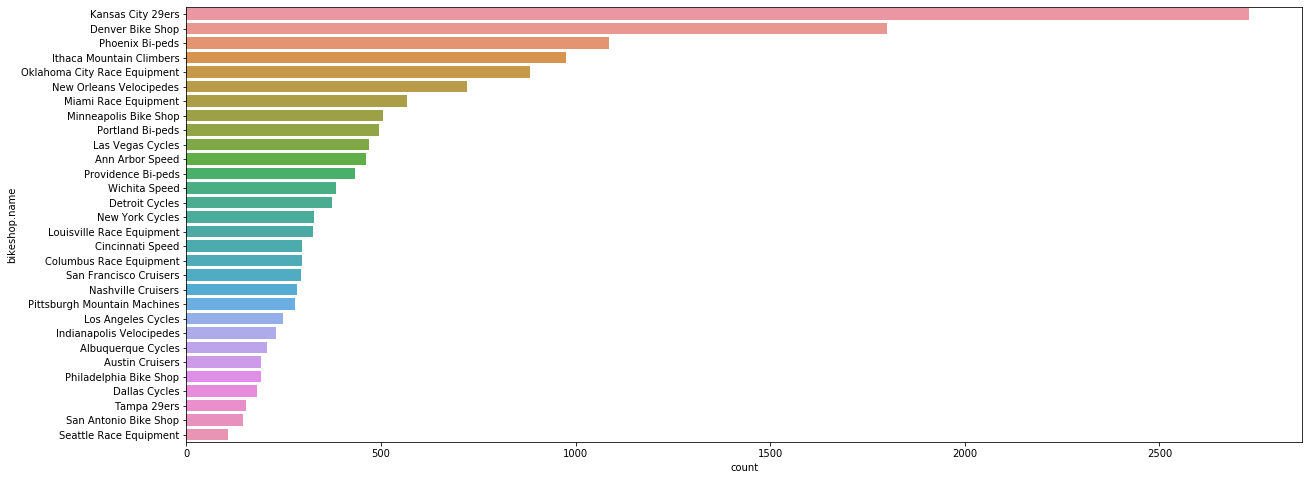

In [21]:
# distribution of customers
plt.figure(figsize= (20,8))
sns.countplot(y = bike_order_shop["bikeshop.name"], order = bike_order_shop['bikeshop.name'].value_counts().index)

Kansas city 29ers is the most frequent buyer, followed by Denver Bike Shop, Phonix Bi-peds, and Ithaca Mountain Climbers. But that does not give us the scale and size of the customer because we did not consider the quantity each of them bought yet. We can keep this initial observation in mind while carry on with the clustering analysis.

## Spread customers by groups

Spread customers by group of quantity.
Group the data by ```model & model features``` (bikeshop.name', 'model', 'category1', 'category2', 'frame', 'price') and summarize by quantity purchased. use a pivot table to allocate the aggregated quantitties across **different bikeshops.**

In [22]:
# spread customers by group of quantity bought
bike_order_shop.head()

,bike.id,model,category1,category2,frame,price,order.id,order.line,order.date,customer.id,product.id,quantity,bikeshop.id,bikeshop.name,bikeshop.city,bikeshop.state,latitude,longitude
0,1,Supersix Evo Black Inc.,Road,Elite Road,Carbon,High Price,3,3,2011-01-10,6,1,1,6,Louisville Race Equipment,Louisville,KY,38.252665,-85.758456
1,1,Supersix Evo Black Inc.,Road,Elite Road,Carbon,High Price,458,2,2012-05-07,6,1,1,6,Louisville Race Equipment,Louisville,KY,38.252665,-85.758456
2,1,Supersix Evo Black Inc.,Road,Elite Road,Carbon,High Price,469,2,2012-05-18,6,1,1,6,Louisville Race Equipment,Louisville,KY,38.252665,-85.758456
3,1,Supersix Evo Black Inc.,Road,Elite Road,Carbon,High Price,556,12,2012-08-07,6,1,1,6,Louisville Race Equipment,Louisville,KY,38.252665,-85.758456
4,1,Supersix Evo Black Inc.,Road,Elite Road,Carbon,High Price,1178,8,2014-03-27,6,1,1,6,Louisville Race Equipment,Louisville,KY,38.252665,-85.758456


In [23]:
grouped_customers = bike_order_shop.groupby(["bikeshop.name","model","category1","category2","frame","price"])

In [24]:
grouped_customers.first()

bike.id  \
bikeshop.name      model                           category1 category2          frame    price                 
Albuquerque Cycles Bad Habit 1                     Mountain  Trail              Aluminum High Price       79   
                   Bad Habit 2                     Mountain  Trail              Aluminum Low Price        80   
                   Beast of the East 1             Mountain  Trail              Aluminum Low Price        76   
                   Beast of the East 2             Mountain  Trail              Aluminum Low Price        77   
                   Beast of the East 3             Mountain  Trail              Aluminum Low Price        78   
                   CAAD Disc Ultegra               Road      Elite Road         Aluminum Low Price        14   
                   CAAD12 105                      Road      Elite Road         Aluminum Low Price        17   
                   CAAD12 Disc 105                 Road      Elite Road         Aluminum Low Price        16   
                   CAAD12 Disc Dura Ace            Road      Elite Road         Aluminum High Price       12   
                   CAAD12 Red                      Road      Elite Road         Aluminum High Price       13   
                   CAAD12 Ultegra                  Road      Elite Road         Aluminum Low Price        15   
                   CAAD8 105                       Road      Elite Road         Aluminum Low Price        18   
                   CAAD8 Claris                    Road      Elite Road         Aluminum Low Price        21   
                   CAAD8 Sora                      Road      Elite Road         Aluminum Low Price        20   
                   CAAD8 Tiagra                    Road      Elite Road         Aluminum Low Price        19   
                   Catalyst 1                      Mountain  Sport              Aluminum Low Price        94   
                   Catalyst 2                      Mountain  Sport              Aluminum Low Price        95   
                   Catalyst 3                      Mountain  Sport              Aluminum Low Price        96   
                   Catalyst 4                      Mountain  Sport              Aluminum Low Price        97   
                   F-Si 1                          Mountain  Cross Country Race Aluminum Low Price        71   
                   F-Si 2                          Mountain  Cross Country Race Aluminum Low Price        72   
                   F-Si 3                          Mountain  Cross Country Race Aluminum Low Price        73   
                   F-Si Carbon 2                   Mountain  Cross Country Race Carbon   High Price       69   
                   F-Si Carbon 4                   Mountain  Cross Country Race Carbon   Low Price        70   
                   F-Si Hi-Mod 1                   Mountain  Cross Country Race Carbon   High Price       68   
                   F-Si Hi-Mod Team                Mountain  Cross Country Race Carbon   High Price       67   
                   Fat CAAD1                       Mountain  Fat Bike           Aluminum High Price       74   
                   Fat CAAD2                       Mountain  Fat Bike           Aluminum Low Price        75   
                   Habit 4                         Mountain  Trail              Aluminum Low Price        86   
                   Habit 5                         Mountain  Trail              Aluminum Low Price        87   
...                                                                                                      ...   
Wichita Speed      Supersix Evo Black Inc.         Road      Elite Road         Carbon   High Price        1   
                   Supersix Evo Hi-Mod Dura Ace 1  Road      Elite Road         Carbon   High Price        3   
                   Supersix Evo Hi-Mod Dura Ace 2  Road      Elite Road         Carbon   High Price        4   
                   Supersix Evo Hi-Mod Team        Road      Elite Ro

In [25]:
grouped_customers["quantity"].sum().reset_index().head()

,bikeshop.name,model,category1,category2,frame,price,quantity
0,Albuquerque Cycles,Bad Habit 1,Mountain,Trail,Aluminum,High Price,5
1,Albuquerque Cycles,Bad Habit 2,Mountain,Trail,Aluminum,Low Price,2
2,Albuquerque Cycles,Beast of the East 1,Mountain,Trail,Aluminum,Low Price,3
3,Albuquerque Cycles,Beast of the East 2,Mountain,Trail,Aluminum,Low Price,3
4,Albuquerque Cycles,Beast of the East 3,Mountain,Trail,Aluminum,Low Price,1


In [26]:
grouped_quantity = grouped_customers["quantity"].sum().reset_index()

We need to scale (normalize) the quantity data. Unadjusted quantities presents a problem to the k-means algorithm. Some customers are larger than others meaning they purchase higher volumes. Fortunately, we can resolve this issue by converting the customer order quantities to proportion of the total bikes purchased by a customer.

In [27]:
value = np.unique(grouped_quantity["bikeshop.name"])
value,len(value)

(array(['Albuquerque Cycles', 'Ann Arbor Speed', 'Austin Cruisers',
        'Cincinnati Speed', 'Columbus Race Equipment', 'Dallas Cycles',
        'Denver Bike Shop', 'Detroit Cycles', 'Indianapolis Velocipedes',
        'Ithaca Mountain Climbers', 'Kansas City 29ers',
        'Las Vegas Cycles', 'Los Angeles Cycles',
        'Louisville Race Equipment', 'Miami Race Equipment',
        'Minneapolis Bike Shop', 'Nashville Cruisers',
        'New Orleans Velocipedes', 'New York Cycles',
        'Oklahoma City Race Equipment', 'Philadelphia Bike Shop',
        'Phoenix Bi-peds', 'Pittsburgh Mountain Machines',
        'Portland Bi-peds', 'Providence Bi-peds', 'San Antonio Bike Shop',
        'San Francisco Cruisers', 'Seattle Race Equipment', 'Tampa 29ers',
        'Wichita Speed'], dtype=object), 30)

In [28]:
total_by_shop = []
a = bike_order_shop.groupby("bikeshop.name")
for v in value:
    total_by_shop.append(a.get_group(v)["quantity"].sum())
len(total_by_shop)

30

In [29]:
dct = dict(zip(value,total_by_shop)) # customer and total quantity each of them bought

In [30]:
dct.get("Albuquerque Cycles"),dct.get("Wichita Speed"),5/286, 9/507 # test result

(286, 507, 0.017482517482517484, 0.01775147928994083)

## Normalize quantity for each customer

In [31]:
# normalize data
for index,row in grouped_quantity.iterrows():
    grouped_quantity.at[index,"relative quantity"] = row[6]/dct.get(row[0])

In [32]:
grouped_quantity.head()

,bikeshop.name,model,category1,category2,frame,price,quantity,relative quantity
0,Albuquerque Cycles,Bad Habit 1,Mountain,Trail,Aluminum,High Price,5,0.017483
1,Albuquerque Cycles,Bad Habit 2,Mountain,Trail,Aluminum,Low Price,2,0.006993
2,Albuquerque Cycles,Beast of the East 1,Mountain,Trail,Aluminum,Low Price,3,0.010490
3,Albuquerque Cycles,Beast of the East 2,Mountain,Trail,Aluminum,Low Price,3,0.010490
4,Albuquerque Cycles,Beast of the East 3,Mountain,Trail,Aluminum,Low Price,1,0.003497


# K-means clustering

Perform k-means clustering to segment our customer base. Think of clusters as groups in the customer-base. Prior to starting we will need to **choose the number of customer groups, k**, that are to be detected. The best way to do this is to think about the customer base and our **hypothesis**. 

> Hypothesis
> 1. We believe that there are most likely to be at least four customer groups because of mountain bike vs. road bike and premium vs affordable preferences. 
> 2. We also believe there could be more as some customers may not care about price but may still prefer a specific bike category. 

However, we’ll limit the clusters to eight as more is likely to overfit the segments. 

The lgoic behind choosing an appropriate k is decided upon the initial assumption we have and furthre validate the number using statistical method like what we adopted here, the sum of squared distances. In our initial hypothesis, we choose k = 8 because of the business logic behid it. From the elboe method for optimal k we should set k from 4 to 8. So we should set k from 4 to 8 and this confirms with our intial hypothesis. Here, I choose k as 4.

In [33]:
# set up
from sklearn.cluster import KMeans

Some notes on another clustering method: ```K-modes```
The standard k-means algorithm isn't directly applicable to categorical data, for various reasons. The sample space for categorical data is discrete, and doesn't have a natural origin. A Euclidean distance function on such a space isn't really meaningful.

In [34]:
df = grouped_quantity.loc[:,["quantity","relative quantity"]] # the df we will use to perform clustering from above manipulation


In [35]:
# find out the optimal clusters
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df)
    Sum_of_squared_distances.append(km.inertia_)

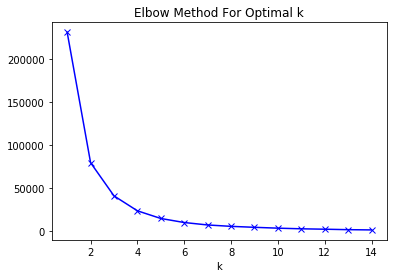

In [36]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.title('Elbow Method For Optimal k')
plt.show()

The lgoic behind choosing an appropriate k is decided upon the initial assumption we have and furthre validate the number using statistical method like what we adopted here, the sum of squared distances. In our initial hypothesis, we choose k = 8 because of the business logic behid it. From the elboe method for optimal k we should set k from 4 to 8. So we should set k from 4 to 8 and this confirms with our intial hypothesis. In this HW, I choose k as 4.

In [37]:
# clustering, k = 4
kmeans = KMeans(n_clusters=4, random_state=0).fit(df)

In [38]:
kmeans.labels_

array([0, 0, 0, ..., 0, 2, 2], dtype=int32)

In [39]:
grouped_quantity["cluster"] = kmeans.labels_
grouped_quantity.head()

,bikeshop.name,model,category1,category2,frame,price,quantity,relative quantity,cluster
0,Albuquerque Cycles,Bad Habit 1,Mountain,Trail,Aluminum,High Price,5,0.017483,0
1,Albuquerque Cycles,Bad Habit 2,Mountain,Trail,Aluminum,Low Price,2,0.006993,0
2,Albuquerque Cycles,Beast of the East 1,Mountain,Trail,Aluminum,Low Price,3,0.010490,0
3,Albuquerque Cycles,Beast of the East 2,Mountain,Trail,Aluminum,Low Price,3,0.010490,0
4,Albuquerque Cycles,Beast of the East 3,Mountain,Trail,Aluminum,Low Price,1,0.003497,0


In [40]:
# see each customer's cluster
cus_cluster = {k : [] for k in value}
for index, row in grouped_quantity.iterrows():
    cus_cluster[row["bikeshop.name"]].append(row["cluster"])

## Which Customers are in Each Segment?

In [41]:
keys = [i for i in range(4)]
cus_cluster = {k : set() for k in keys}
for index, row in grouped_quantity.iterrows():
    cus_cluster[row["cluster"]].add(row["bikeshop.name"])

In [42]:
cus_cluster

{0: {'Albuquerque Cycles',
  'Ann Arbor Speed',
  'Austin Cruisers',
  'Cincinnati Speed',
  'Columbus Race Equipment',
  'Dallas Cycles',
  'Denver Bike Shop',
  'Detroit Cycles',
  'Indianapolis Velocipedes',
  'Ithaca Mountain Climbers',
  'Kansas City 29ers',
  'Las Vegas Cycles',
  'Los Angeles Cycles',
  'Louisville Race Equipment',
  'Miami Race Equipment',
  'Minneapolis Bike Shop',
  'Nashville Cruisers',
  'New Orleans Velocipedes',
  'New York Cycles',
  'Oklahoma City Race Equipment',
  'Philadelphia Bike Shop',
  'Phoenix Bi-peds',
  'Pittsburgh Mountain Machines',
  'Portland Bi-peds',
  'Providence Bi-peds',
  'San Antonio Bike Shop',
  'San Francisco Cruisers',
  'Seattle Race Equipment',
  'Tampa 29ers',
  'Wichita Speed'},
 1: {'Denver Bike Shop',
  'Ithaca Mountain Climbers',
  'Kansas City 29ers',
  'Las Vegas Cycles',
  'Miami Race Equipment',
  'New Orleans Velocipedes',
  'Oklahoma City Race Equipment',
  'Phoenix Bi-peds',
  'Wichita Speed'},
 2: {'Albuquerque C

# Analyze the result -  Determining the Preferences of the Customer Segments

We need to get actionalbe insights to understand the customer demand after we did the ```k-means``` clustering. This can be done by inspecting the bike model features group by their price, categories, and top models for each customer cluster.

In [44]:
df = grouped_quantity # df we will use for later analysis

### Cluster one

In [60]:
# customer names
print(cus_cluster[0])

{'Los Angeles Cycles', 'Nashville Cruisers', 'Detroit Cycles', 'Austin Cruisers', 'Oklahoma City Race Equipment', 'Seattle Race Equipment', 'Denver Bike Shop', 'San Francisco Cruisers', 'Kansas City 29ers', 'Louisville Race Equipment', 'San Antonio Bike Shop', 'Dallas Cycles', 'Phoenix Bi-peds', 'Tampa 29ers', 'Minneapolis Bike Shop', 'Indianapolis Velocipedes', 'Ann Arbor Speed', 'Albuquerque Cycles', 'Pittsburgh Mountain Machines', 'Portland Bi-peds', 'New York Cycles', 'Ithaca Mountain Climbers', 'Providence Bi-peds', 'Wichita Speed', 'Philadelphia Bike Shop', 'Columbus Race Equipment', 'Miami Race Equipment', 'Las Vegas Cycles', 'New Orleans Velocipedes', 'Cincinnati Speed'}


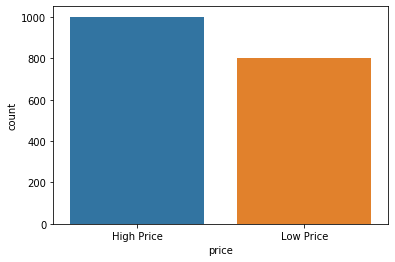

In [81]:
# price range
sns.countplot(df.groupby("cluster").get_group(0)["price"], 
              order = df.groupby("cluster").get_group(0)["price"].value_counts().index)
plt.show()

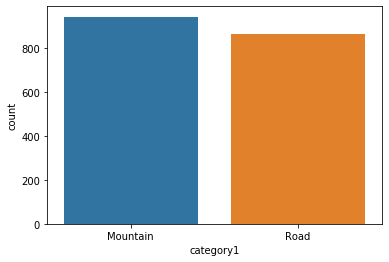

In [50]:
# mountain or road
sns.countplot(df.groupby("cluster").get_group(0)["category1"], 
              order = df.groupby("cluster").get_group(0)["category1"].value_counts().index)
plt.show()

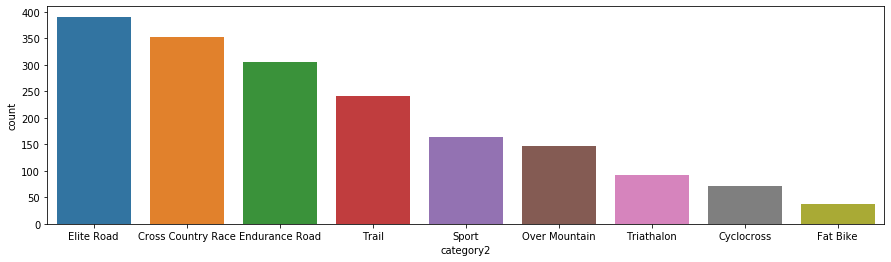

In [55]:
# road preference
plt.figure(figsize = (15,4))
sns.countplot(df.groupby("cluster").get_group(0)["category2"], 
              order = df.groupby("cluster").get_group(0)["category2"].value_counts().index)
plt.show()

Our result pretty much align with the finding for cluster one on the original example, that cluster one for customers like ```Los Angeles Cycles, Nashville Cruisers, Detroit Cycles```,predominantly is ```high-end``` (High Price, Elite Road, Cross Country Race, Endurance Road) and ```Mountain```. The following model name distribution gives an idea of the exact model name that has these above attributes. But the attributes of these models are the ones that we care about the most because they are most actionable.

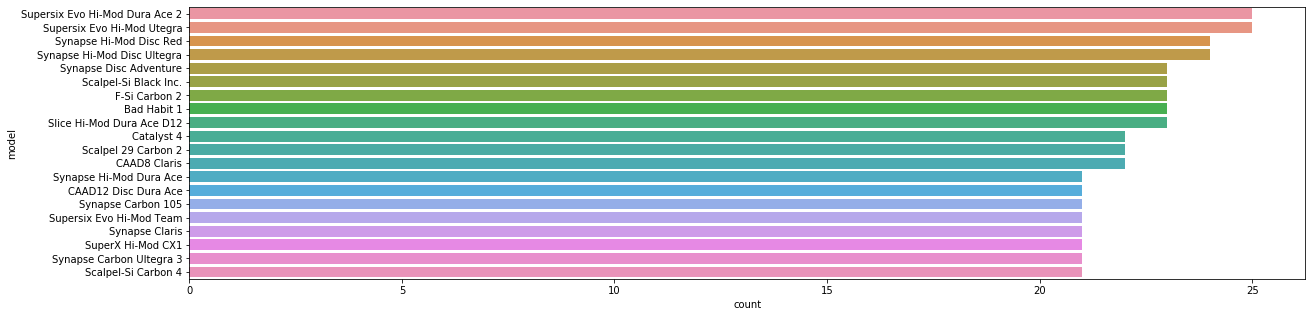

In [63]:
# top 20 model names for cluste one customers
plt.figure(figsize = (20,5))
sns.countplot(y = df.groupby("cluster").get_group(0)["model"], 
              order = df.groupby("cluster").get_group(0)["model"].value_counts().index[:20])

### Cluster two

In [87]:
# customer names
print(cus_cluster[1])

{'Phoenix Bi-peds', 'Oklahoma City Race Equipment', 'Ithaca Mountain Climbers', 'Denver Bike Shop', 'Las Vegas Cycles', 'New Orleans Velocipedes', 'Wichita Speed', 'Kansas City 29ers', 'Miami Race Equipment'}


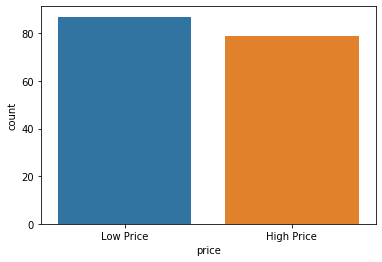

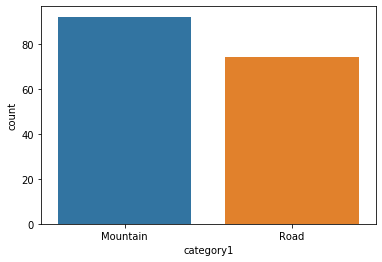

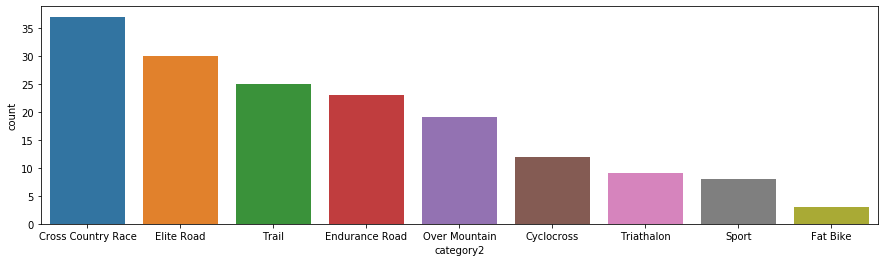

In [56]:
# price range
sns.countplot(df.groupby("cluster").get_group(1)["price"], 
              order = df.groupby("cluster").get_group(1)["price"].value_counts().index)
plt.show()

# mountain or trial
sns.countplot(df.groupby("cluster").get_group(1)["category1"], 
              order = df.groupby("cluster").get_group(1)["category1"].value_counts().index)
plt.show()

# road preference
plt.figure(figsize = (15,4))
sns.countplot(df.groupby("cluster").get_group(1)["category2"], 
              order = df.groupby("cluster").get_group(1)["category2"].value_counts().index)
plt.show()

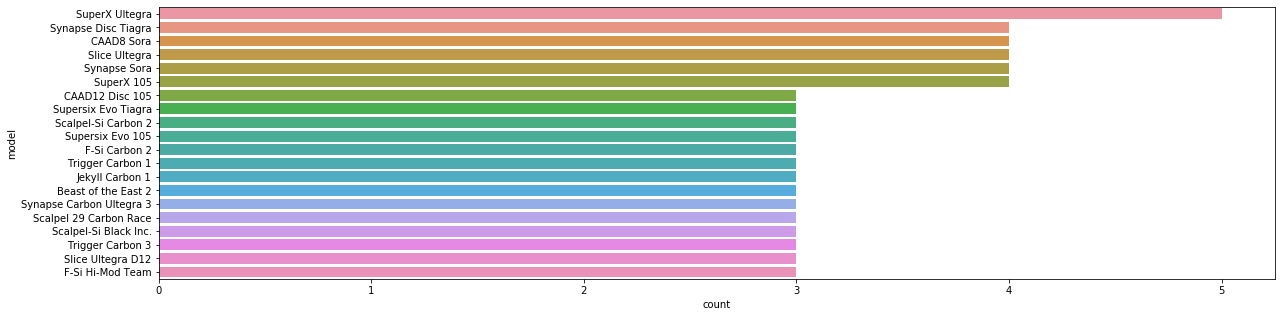

In [74]:
# top 20 model names for cluste one customers
plt.figure(figsize = (20,5))
sns.countplot(y = df.groupby("cluster").get_group(1)["model"], 
              order = df.groupby("cluster").get_group(1)["model"].value_counts().index[:20])

Customers like Phoenix Bi-peds and Oklahoma City Race Equipment prefer low end mountain bikes.

### Cluster three

In [88]:
# customer names
print(cus_cluster[2])

{'Los Angeles Cycles', 'Nashville Cruisers', 'Detroit Cycles', 'Austin Cruisers', 'Oklahoma City Race Equipment', 'Denver Bike Shop', 'San Francisco Cruisers', 'Kansas City 29ers', 'Louisville Race Equipment', 'San Antonio Bike Shop', 'Dallas Cycles', 'Phoenix Bi-peds', 'Tampa 29ers', 'Minneapolis Bike Shop', 'Indianapolis Velocipedes', 'Ann Arbor Speed', 'Albuquerque Cycles', 'Pittsburgh Mountain Machines', 'Portland Bi-peds', 'New York Cycles', 'Ithaca Mountain Climbers', 'Providence Bi-peds', 'Wichita Speed', 'Philadelphia Bike Shop', 'Columbus Race Equipment', 'Miami Race Equipment', 'Las Vegas Cycles', 'New Orleans Velocipedes', 'Cincinnati Speed'}


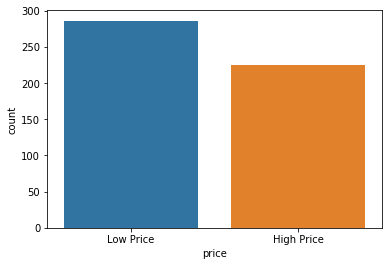

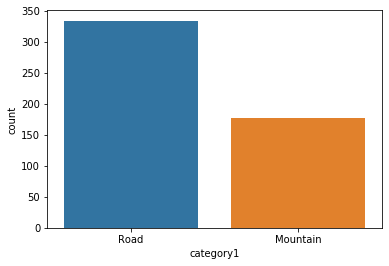

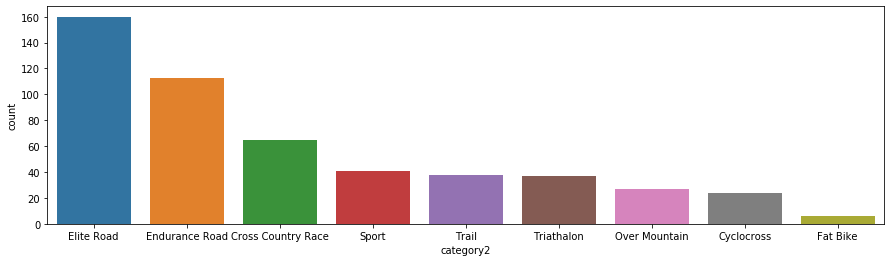

In [57]:
# price range
sns.countplot(df.groupby("cluster").get_group(2)["price"], 
              order = df.groupby("cluster").get_group(2)["price"].value_counts().index)
plt.show()

# mountain or trial
sns.countplot(df.groupby("cluster").get_group(2)["category1"], 
              order = df.groupby("cluster").get_group(2)["category1"].value_counts().index)
plt.show()

# road preference
plt.figure(figsize = (15,4))
sns.countplot(df.groupby("cluster").get_group(2)["category2"], 
              order = df.groupby("cluster").get_group(2)["category2"].value_counts().index)
plt.show()

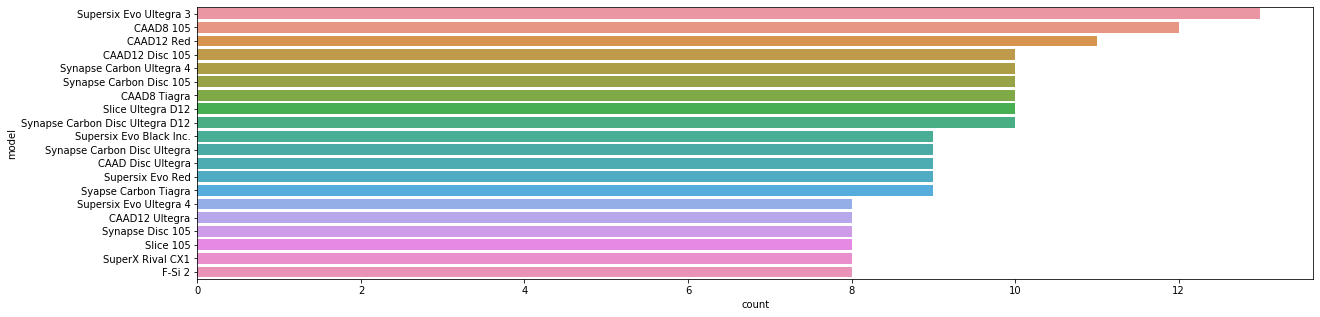

In [75]:
# top 20 model names for cluste one customers
plt.figure(figsize = (20,5))
sns.countplot(y = df.groupby("cluster").get_group(2)["model"], 
              order = df.groupby("cluster").get_group(2)["model"].value_counts().index[:20])

Cluster three prefer low price road bikes.

### Cluster 4

In [66]:
# customer names
print(cus_cluster[3])

{'Denver Bike Shop', 'Kansas City 29ers'}


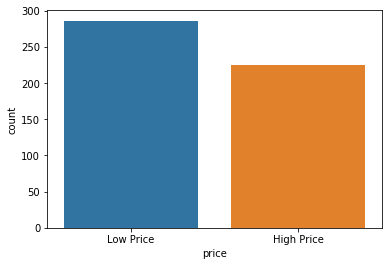

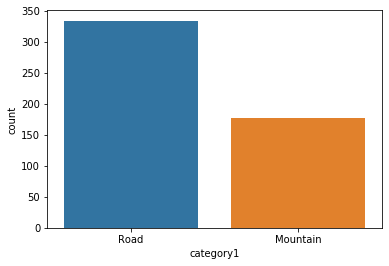

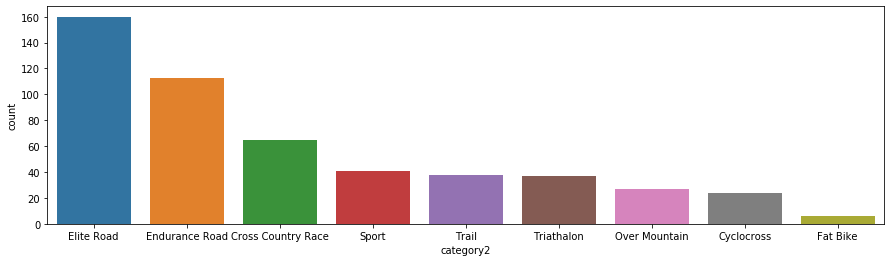

In [67]:
# price range
sns.countplot(df.groupby("cluster").get_group(2)["price"], 
              order = df.groupby("cluster").get_group(2)["price"].value_counts().index)
plt.show()

# mountain or trial
sns.countplot(df.groupby("cluster").get_group(2)["category1"], 
              order = df.groupby("cluster").get_group(2)["category1"].value_counts().index)
plt.show()

# road preference
plt.figure(figsize = (15,4))
sns.countplot(df.groupby("cluster").get_group(2)["category2"], 
              order = df.groupby("cluster").get_group(2)["category2"].value_counts().index)
plt.show()

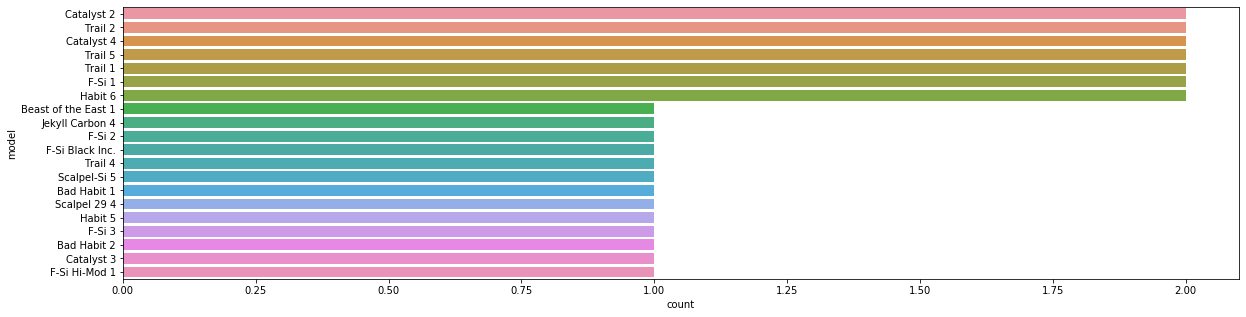

In [76]:
# top 20 model names for cluste one customers
plt.figure(figsize = (20,5))
sns.countplot(y = df.groupby("cluster").get_group(3)["model"], 
              order = df.groupby("cluster").get_group(3)["model"].value_counts().index[:20])

Cluster four customers, Denver Bike Shop and Kansas City 29ers prefer Low Price Road bikes. Noted that these two customers are among the most frequent buyers in terms of the total quantity bought.

# Hierarchical Clustering
Hierarchical clustering is a general family of clustering algorithms that build nested clusters by merging or splitting them successively. This hierarchy of clusters is represented as a tree (or dendrogram). The root of the tree is the unique cluster that gathers all the samples, the leaves being the clusters with only one sample. (from Scikit-learn documentation)

In [97]:
df = grouped_quantity.loc[:,["quantity","relative quantity"]] # the df we will use to perform clustering

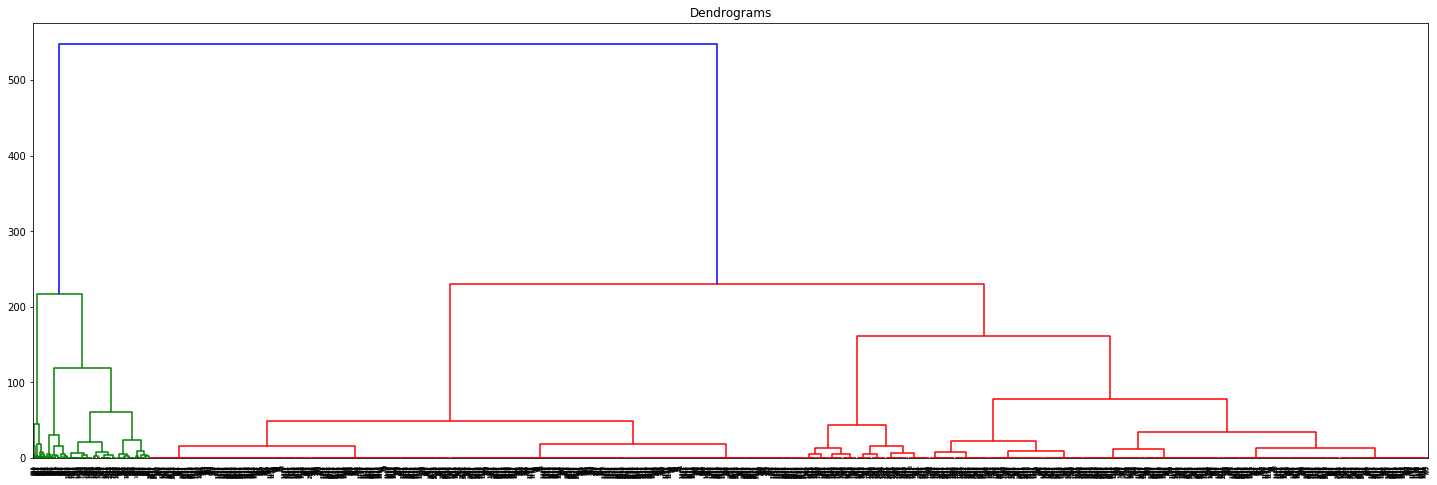

In [99]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize = (25,8))
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(df
                                  , method='ward'))

The x-axis contains the samples and y-axis represents the distance between these samples. The vertical line with maximum distance is the blue line and hence we can decide a threshold of 300 and cut the dendrogram and so we have two clusters so we set n_clusters = 2.

In [91]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
cluster.fit_predict(df)

array([0, 0, 0, ..., 0, 0, 0])

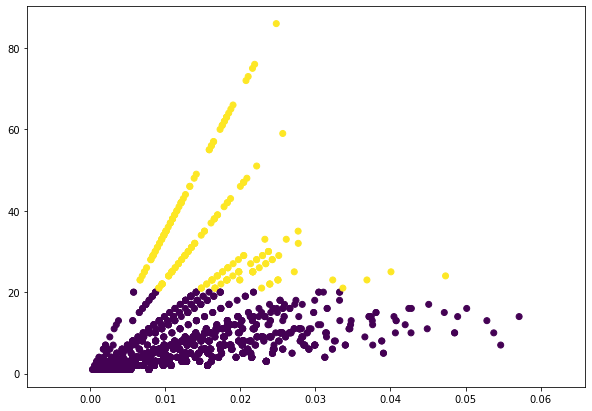

In [95]:
plt.figure(figsize=(10, 7))  
plt.scatter(grouped_quantity['relative quantity'], grouped_quantity['quantity'], c=cluster.labels_) 

## Difference between k-means and hierarchical clustering in our dataset
We know that the hierarchical clustering gives us two clusters. Now let's further understand what are the differences in terms of the customer demand between the two methodologies.

In [101]:
grouped_quantity["h_cluster"] = cluster.labels_

In [104]:
df = grouped_quantity # the df used for analysis

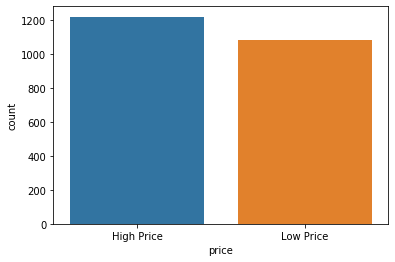

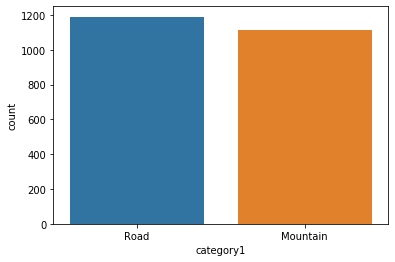

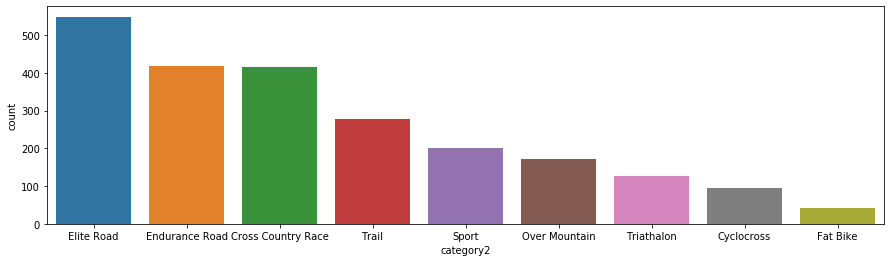

In [105]:
# price range
sns.countplot(df.groupby("h_cluster").get_group(0)["price"], 
              order = df.groupby("h_cluster").get_group(0)["price"].value_counts().index)
plt.show()

# mountain or trial
sns.countplot(df.groupby("h_cluster").get_group(0)["category1"], 
              order = df.groupby("h_cluster").get_group(0)["category1"].value_counts().index)
plt.show()

# road preference
plt.figure(figsize = (15,4))
sns.countplot(df.groupby("h_cluster").get_group(0)["category2"], 
              order = df.groupby("h_cluster").get_group(0)["category2"].value_counts().index)
plt.show()

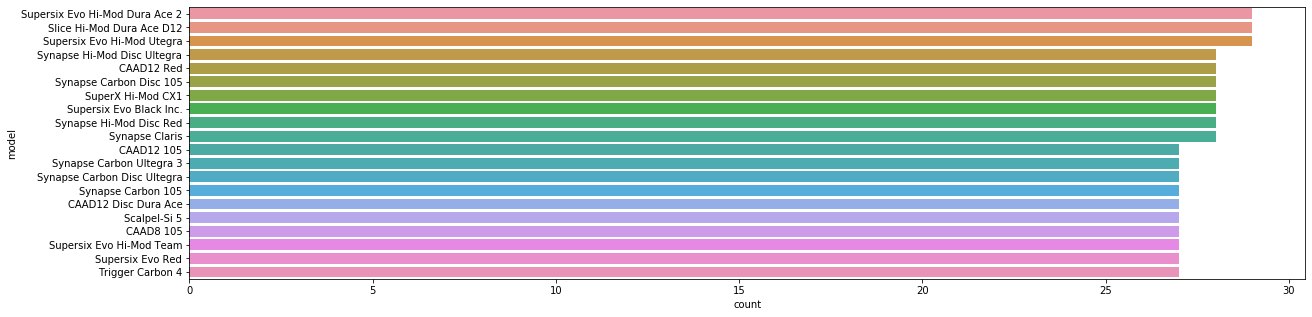

In [107]:
# top 20 model names for the first cluster
plt.figure(figsize = (20,5))
sns.countplot(y = df.groupby("h_cluster").get_group(0)["model"], 
              order = df.groupby("h_cluster").get_group(0)["model"].value_counts().index[:20])

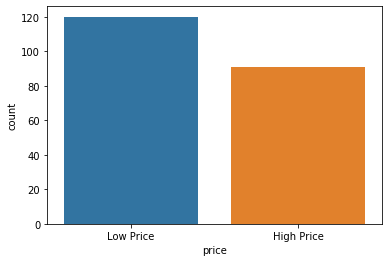

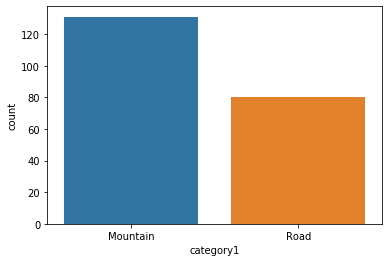

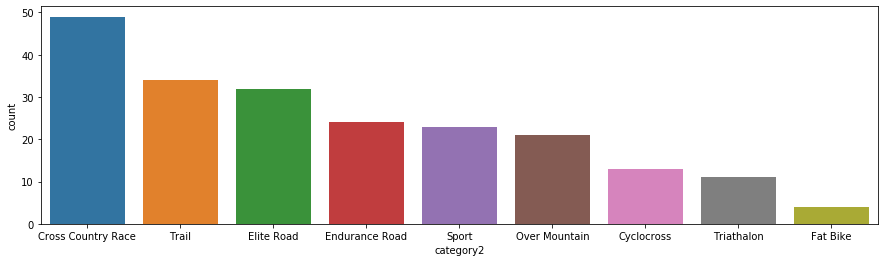

In [106]:
# price range
sns.countplot(df.groupby("h_cluster").get_group(1)["price"], 
              order = df.groupby("h_cluster").get_group(1)["price"].value_counts().index)
plt.show()

# mountain or trial
sns.countplot(df.groupby("h_cluster").get_group(1)["category1"], 
              order = df.groupby("h_cluster").get_group(1)["category1"].value_counts().index)
plt.show()

# road preference
plt.figure(figsize = (15,4))
sns.countplot(df.groupby("h_cluster").get_group(1)["category2"], 
              order = df.groupby("h_cluster").get_group(1)["category2"].value_counts().index)
plt.show()

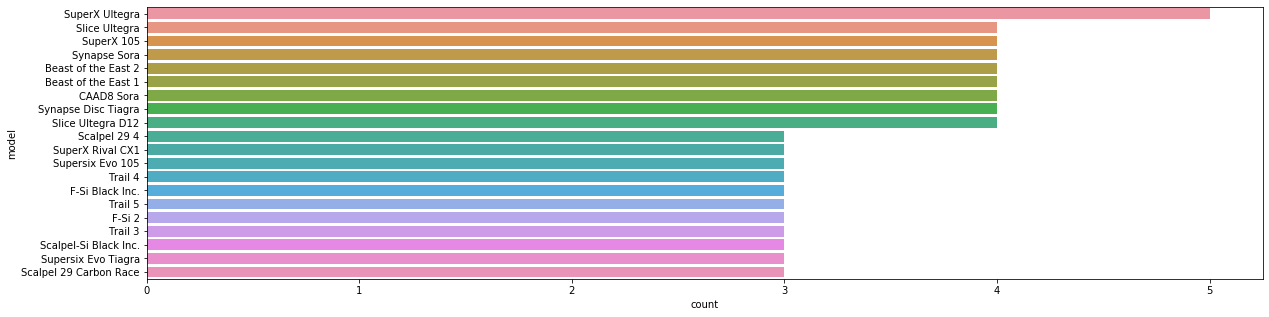

In [108]:
# top 20 model names for the first cluster
plt.figure(figsize = (20,5))
sns.countplot(y = df.groupby("h_cluster").get_group(1)["model"], 
              order = df.groupby("h_cluster").get_group(1)["model"].value_counts().index[:20])

So we know that for categories that have binary classes like Mountain and Road, High Price and Low Price, the hierarchical clustering captures exactly two clusters with the direct opposite for each cluster. However, with k-means clustering we have more dimensions in terms of the different combination of the customer's need.